In [1]:
import tensorflow as tf
import numpy as np
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import clone_model
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from numpy.random import default_rng
from tensorflow.keras.models import load_model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

2024-10-29 17:16:59.285736: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 17:16:59.312422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 17:16:59.312454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 17:16:59.313266: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 17:16:59.318057: I tensorflow/core/platform/cpu_feature_guar

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [3]:
train_images, test_images = train_images / 255.0, test_images / 255.0

In [4]:
train_images.shape

(50000, 32, 32, 3)

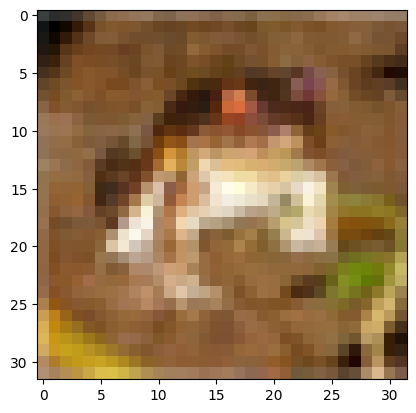

In [5]:
plt.imshow(train_images[0])

In [6]:
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [7]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

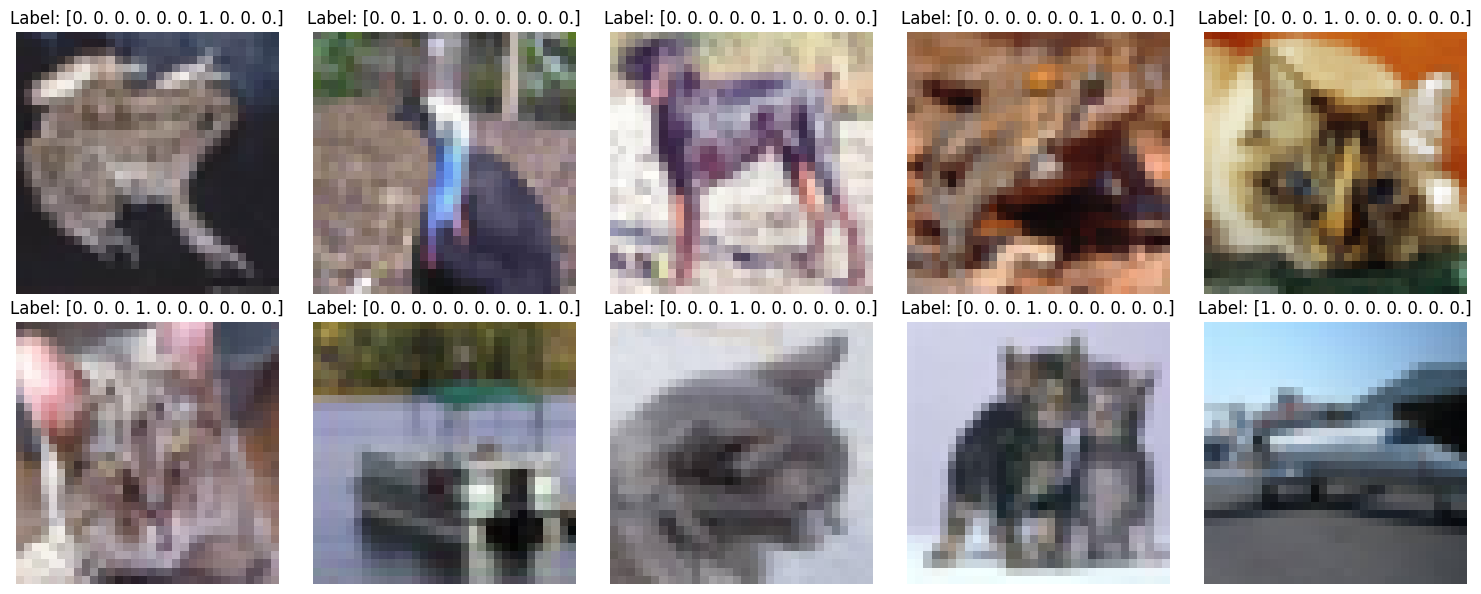

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for img, lbl, ax in zip(train_images, train_labels, axes):
    ax.imshow(img)
    ax.set_title(f'Label: {lbl}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [10]:
'''model_list = []

for i in range(10):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3), name='conv1'),
        MaxPooling2D((2,2), name='pool1'),
        Conv2D(64, (3,3), activation='relu', name='conv2'),
        MaxPooling2D((2,2), name='pool2'),
        Conv2D(64, (3,3), activation='relu', name='conv3'),
        Flatten(name='flatten'),
        Dense(64, activation='relu', name='fc1'),
        Dense(10, activation='softmax', name='output')
        ])
    model_list.append(model)'''
model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(64, (3,3), activation='relu', padding='same', name='conv3'),
        Conv2D(64, (3,3), activation='relu', padding='same',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(128, (3,3), activation='relu', padding='same',  name='conv5'),
        Conv2D(128, (3,3), activation='relu', padding='same',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(256, (3,3), activation='relu', padding='same',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(128, activation='relu', name='fc1'),
        Dense(64, activation='relu', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

2024-10-29 17:17:03.437694: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 17:17:03.459518: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 17:17:03.459652: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 64)          0

In [12]:
def get_flops(model, input_shape):
    # Create a concrete function from the Keras model
    @tf.function
    def model_func(x):
        return model(x)
    
    # Get the concrete function
    concrete_func = model_func.get_concrete_function(tf.TensorSpec(input_shape, model.inputs[0].dtype))
    
    # Convert variables to constants and get the frozen graph
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    frozen_graph = frozen_func.graph.as_graph_def()
    
    # Use TensorFlow's profiler
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(frozen_graph, name='')
        run_meta = tf.compat.v1.RunMetadata()
        with tf.compat.v1.Session(graph=graph) as sess:
            flops = tf.compat.v1.profiler.profile(
                graph=graph,
                run_meta=run_meta,
                cmd='op',
                options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            )
            return flops.total_float_ops

In [13]:
'''for i in model_list:
    i.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    i.fit(X, y_one_hot, epochs=100, batch_size=2)
    loss_list.append(i.evaluate(X, y_one_hot)[0])
    accuracy_list.append(i.evaluate(X, y_one_hot)[1])'''
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=100, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/100


2024-10-29 17:17:22.430369: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-10-29 17:17:22.551761: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-10-29 17:17:23.322632: I external/local_xla/xla/service/service.cc:168] XLA service 0x70acffe7bbc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-29 17:17:23.322650: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-10-29 17:17:23.326310: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730189843.375989 1282568 device_compiler.h:186] Compiled cluster using XL

625/625 [==============================] - 9s 8ms/step - loss: 1.8261 - accuracy: 0.3065 - val_loss: 1.6236 - val_accuracy: 0.4179
Epoch 2/100
625/625 [==============================] - 4s 7ms/step - loss: 1.3805 - accuracy: 0.4954 - val_loss: 1.1855 - val_accuracy: 0.5747
Epoch 3/100
625/625 [==============================] - 5s 7ms/step - loss: 1.1377 - accuracy: 0.5932 - val_loss: 1.0090 - val_accuracy: 0.6474
Epoch 4/100
625/625 [==============================] - 4s 7ms/step - loss: 0.9995 - accuracy: 0.6449 - val_loss: 0.8929 - val_accuracy: 0.6870
Epoch 5/100
625/625 [==============================] - 4s 7ms/step - loss: 0.9175 - accuracy: 0.6771 - val_loss: 0.8094 - val_accuracy: 0.7149
Epoch 6/100
625/625 [==============================] - 4s 7ms/step - loss: 0.8416 - accuracy: 0.7048 - val_loss: 0.7923 - val_accuracy: 0.7259
Epoch 7/100
625/625 [==============================] - 4s 7ms/step - loss: 0.7828 - accuracy: 0.7251 - val_loss: 0.7366 - val_accuracy: 0.7434
Epoch 8/100

In [14]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)


313/313 - 1s - loss: 0.6317 - accuracy: 0.8197 - 720ms/epoch - 2ms/step


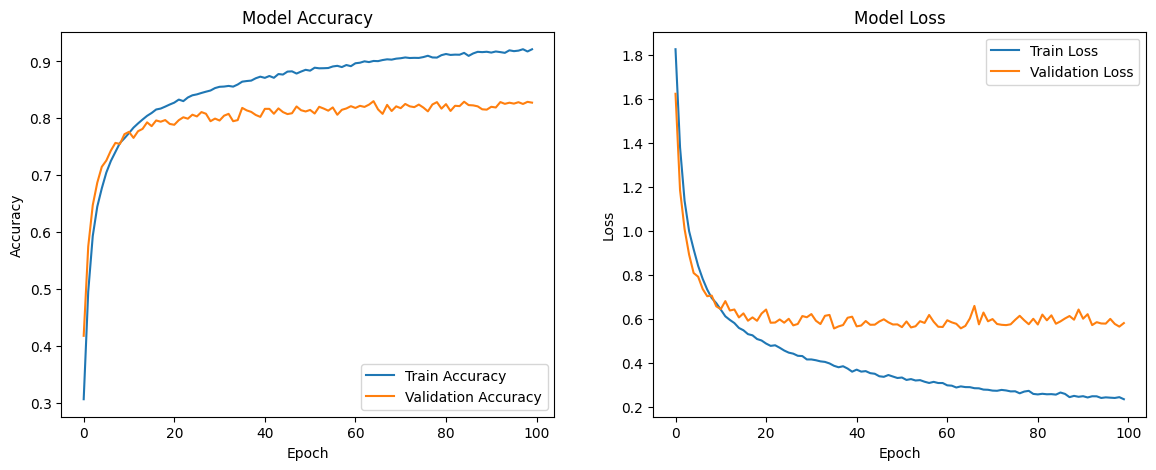

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()


In [16]:
#for idx, model in enumerate(model_list):
#    model.save(f'model_{idx}.h5')
get_flops(model, train_images.shape)

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


2024-10-29 17:26:25.223218: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 17:26:25.223338: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-10-29 17:26:25.223398: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-10-29 17:26:25.223611: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 17:26:25.223705: I external/local_xla/xla/stream_executor/cuda/cuda_e


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================


3486576480000


Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profile:
node name | # float_ops
Conv2D                   3468.17b float_ops (100.00%, 99.47%)
MatMul                   11.19b float_ops (0.53%, 0.32%)
BiasAdd                  4.76b float_ops (0.21%, 0.14%)
MaxPool                  2.46b float_ops (0.07%, 0.07%)
Softmax                  2.00m float_ops (0.00%, 0.00%)

======================End of Report==========================


In [17]:
def get_layer(model, layer_index):
    return [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)][layer_index]

def get_filters(model, layer_index, filter_indices):
    layer = get_layer(model, layer_index)
    filters, biases = layer.get_weights()
    return filters[:, :, :, filter_indices]

def get_all_filters(model, layer_name):
    layer = model.get_layer(name=layer_name)
    filters, biases = layer.get_weights()
    return filters



In [18]:
get_all_filters(model, 'conv1').shape

(3, 3, 3, 32)

In [33]:
'''def norms(model_index, layer_index, model_list):    
    model_norm_list = []
    for model_idx, model in enumerate(model_list):
        #print(model_idx)
        layer_norm_list = []
        for layer_idx, layer in enumerate([layer for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]):
            #print(layer_idx)
            norm_list = []
            filters, biases = layer.get_weights()
            num_filters = filters.shape[-1]
            for i in range(num_filters):
                
                filt = filters[:, :, :, i]
                filt_matrix = filt.reshape(-1, filt.shape[-1])
                norm = np.linalg.norm(filt_matrix)
                norm_list.append(norm)
            layer_norm_list.append(norm_list)
        model_norm_list.append(layer_norm_list)
    return model_norm_list[model_index][layer_index]'''

'''def get_norm(model, layer_name):
    layer = model.get_layer(layer_name)
    filters, biases = layer.get_weights()
    num_filters = filters.shape[-1]
    norms = []
    for i in range(num_filters):
        filt = filters[:, :, :, i]
        filt_matrix = filt.reshape(-1, filt.shape[-1])
        norm = np.linalg.norm(filt_matrix)
        norms.append(norm)
    return norms'''

def get_filter_uniqueness(model, layer_name):
    layer = model.get_layer(layer_name)
    filters, biases = layer.get_weights()
    num_filters = filters.shape[-1]
    uniqueness_list = []
    for i in range(num_filters):
        filt = filters[:, :, :, i]
        filt_matrix = filt.reshape(-1, filt.shape[-1])
        uniqueness = np.linalg.norm(filt_matrix) - np.linalg.norm(get_all_filters(model, layer_name))

        uniqueness_list.append(uniqueness)
    return uniqueness_list

uniqueness_conv3 = get_filter_uniqueness(model, 'conv3')
uniqueness_conv4 = get_filter_uniqueness(model, 'conv4')
uniqueness_conv5 = get_filter_uniqueness(model, 'conv5')
uniqueness_conv6 = get_filter_uniqueness(model, 'conv6')
uniqueness_conv7 = get_filter_uniqueness(model, 'conv7')




    


In [34]:
def filter_to_zero(norms, percentage):
    threshold = np.percentile(norms, percentage)
    return [i for i, norm in enumerate(norms) if norm < threshold]

def filter_to_keep(norms, percentage):
    threshold = np.percentile(norms, percentage)
    return [i for i, norm in enumerate(norms) if norm >= threshold]

In [50]:
keep_filt_conv3 = filter_to_keep(uniqueness_conv3, 50)
keep_filt_conv4 = filter_to_keep(uniqueness_conv4, 50)
keep_filt_conv5 = filter_to_keep(uniqueness_conv5, 70)
keep_filt_conv6 = filter_to_keep(uniqueness_conv6, 70)
keep_filt_conv7 = filter_to_keep(uniqueness_conv7, 90)

In [51]:
'''pruned_target_model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=X.shape[1:], name='target_conv1'),
        MaxPooling2D((2,2), name='target_pool1'),
        Conv2D(len(keep_filt), (3,3), activation='relu', name='target_conv2'),
        MaxPooling2D((2,2), name='target_pool2'),
        Flatten(name='target_flatten'),
        Dense(len(keep_filt), activation='relu', name='target_fc1'),
        Dense(10, activation='softmax', name='target_output')
        ])'''

pruned_target_model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3), (3,3), activation='relu', padding='same', name='conv3'),
        Conv2D(len(keep_filt_conv4), (3,3), activation='relu', padding='same',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5), (3,3), activation='relu', padding='same',  name='conv5'),
        Conv2D(len(keep_filt_conv6), (3,3), activation='relu', padding='same',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7), (3,3), activation='relu', padding='same',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7), activation='relu', name='fc1'),
        Dense(64, activation='relu', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [52]:
pruned_target_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 dropout_16 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 conv4 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 32)         

In [53]:
'''def copy_weights_pruned(source_model, pruned_target_model, source_layer_name, target_layer_name):
    for source_layer, target_layer in zip(source_model.layers, pruned_target_model.layers):
        if isinstance(source_layer, tf.keras.layers.Conv2D) and source_layer.name != source_layer_name and target_layer.name != target_layer_name:
            w, b = source_layer.get_weights()
            target_layer.set_weights([w, b])
        elif source_layer.name == source_layer_name and target_layer.name == target_layer_name:
            w, b = source_layer.get_weights()
            target_layer.set_weights([w[:, :, :, keep_filt], b[keep_filt]])'''
def get_var_name(var):
    for name, value in locals().items():
        if value is var:
            return name

def copy_weights_pruned(source_model, pruned_target_model, source_layer_names, target_layer_names, keep_filters):
    for source_layer, target_layer in zip(source_model.layers, pruned_target_model.layers):
        if isinstance(source_layer, tf.keras.layers.Conv2D) and source_layer.name not in source_layer_names and target_layer.name not in target_layer_names:
            w, b = source_layer.get_weights()
            target_layer.set_weights([w, b])
        elif source_layer.name in source_layer_names and target_layer.name in target_layer_names:
            for keep_filt in keep_filters:
                if source_layer.name in get_var_name(keep_filt):
                    w, b = source_layer.get_weights()
                    target_layer.set_weights([w[:, :, :, keep_filt], b[keep_filt]])
               
        

In [54]:
copy_weights_pruned(model, pruned_target_model, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3, keep_filt_conv4, keep_filt_conv5, keep_filt_conv6, keep_filt_conv7])

In [55]:
pruned_target_model.get_layer('conv3').get_weights()[0].shape

(3, 3, 32, 32)

In [56]:
pruned_target_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model.fit(train_images, train_labels, epochs=100, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/100


2024-10-29 17:55:20.450983: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 6s 6ms/step - loss: 1.7860 - accuracy: 0.3043 - val_loss: 1.3300 - val_accuracy: 0.4873
Epoch 2/100
625/625 [==============================] - 3s 5ms/step - loss: 1.3006 - accuracy: 0.5161 - val_loss: 1.0453 - val_accuracy: 0.6194
Epoch 3/100
625/625 [==============================] - 3s 6ms/step - loss: 1.0944 - accuracy: 0.6078 - val_loss: 0.9345 - val_accuracy: 0.6601
Epoch 4/100
625/625 [==============================] - 3s 5ms/step - loss: 1.0157 - accuracy: 0.6387 - val_loss: 0.8775 - val_accuracy: 0.6839
Epoch 5/100
625/625 [==============================] - 3s 5ms/step - loss: 0.9473 - accuracy: 0.6635 - val_loss: 0.8313 - val_accuracy: 0.7036
Epoch 6/100
625/625 [==============================] - 4s 6ms/step - loss: 0.9083 - accuracy: 0.6791 - val_loss: 0.8162 - val_accuracy: 0.7079
Epoch 7/100
625/625 [==============================] - 3s 6ms/step - loss: 0.8720 - accuracy: 0.6905 - val_loss: 0.7924 - val_accuracy: 0.7164
Epoch 8/100

In [57]:
test_loss, test_acc = pruned_target_model.evaluate(test_images, test_labels, verbose=2)


313/313 - 1s - loss: 0.6071 - accuracy: 0.8019 - 502ms/epoch - 2ms/step


In [58]:
get_flops(pruned_target_model, train_images.shape)


=========================Options=============================


2024-10-29 18:00:38.147642: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 18:00:38.147739: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-10-29 18:00:38.147785: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-10-29 18:00:38.147966: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 18:00:38.148060: I external/local_xla/xla/stream_executor/cuda/cuda_e

1348172400000

-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profile:
node name | # float_ops
Conv2D     

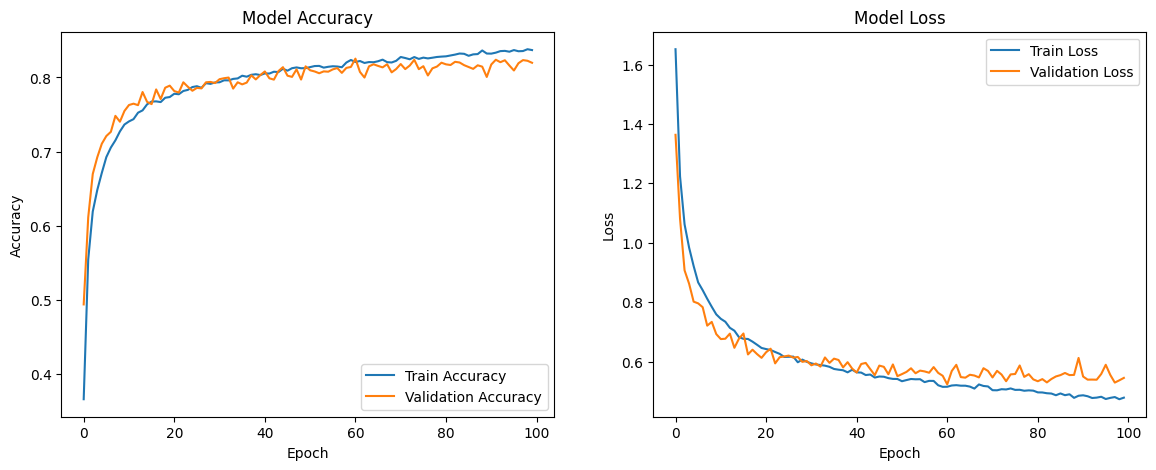

In [31]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()


In [32]:
model.save('model_uniqueness.h5')
pruned_target_model.save('pruned_target_model_uniqueness.h5')

/home/am/Documents/VirtualEnv/tensorflow-gpu/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
